In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from trajectory import Trajectory

traj = Trajectory("../res/tristan_md_trajectory_N125_F500_L10.0.xyz")
traj._elements.dtype

dtype('<U2')

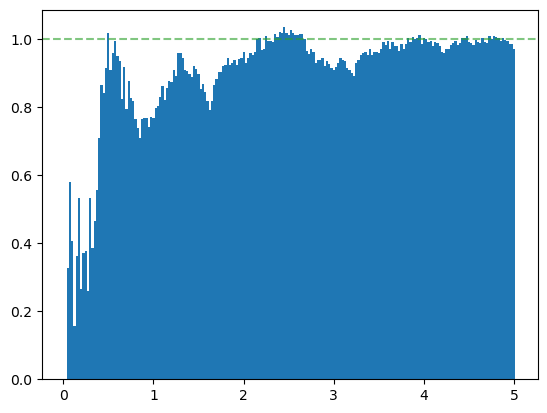

In [18]:
plt.bar(r_bins[1:], c, width=r_bins[1])
plt.axhline(y=1, linestyle = '--', color='tab:green', alpha=.6)
plt.show()